In [95]:
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

In [96]:
installs = pd.read_csv('data/installs.csv.gzip', low_memory=False, compression='gzip', parse_dates = ['created'], index_col=['created'])
installs = installs.sort_index()

In [97]:
a_predecir = pd.read_csv("final.csv", names=["ref_hash"])

In [98]:
ventana_1 = installs

In [99]:
train_ventana_2 = installs['2019-04-21':'2019-04-23'].reset_index().groupby('ref_hash').agg({'created' : 'min'}).reset_index()

In [100]:
train_ventana_2['created'] = train_ventana_2['created'] - pd.Timestamp('2019-04-21 00:00:00')
train_ventana_2['created'] = train_ventana_2['created'].transform(lambda x: x.total_seconds())

In [101]:
train_ventana_2 = train_ventana_2.merge(ventana_1["ref_hash"].drop_duplicates(), how="right")

In [102]:
a_predecir

,ref_hash
0,1000169251625791246
1,1000395625957344683
2,1003027494996471685
3,1006670001679961544
4,1007573308966476713
5,1010070503877148763
6,1010265377387765028
7,1010531372912327058
8,1011610998357271358
9,1013543838965040946


In [103]:
a_predecir = a_predecir.merge(ventana_1["ref_hash"].drop_duplicates(), how="inner")

In [104]:
a_predecir = a_predecir.sort_values(["ref_hash"]).reset_index(drop=True)

In [105]:
train_ventana_2 = train_ventana_2.sort_values(["ref_hash"]).reset_index(drop=True)

In [106]:
train_ventana_2["created"].fillna(60*60*24*3, inplace=True)

In [107]:
train_vent_2 = train_ventana_2["created"]
hash_a_pred = train_ventana_2["ref_hash"]

In [108]:
ventana_1 = ventana_1.reset_index()

In [109]:
ventana_1['created'] = ventana_1['created'] - pd.Timestamp('2019-04-18 00:00:00')
ventana_1['created'] = ventana_1['created'].transform(lambda x: x.total_seconds())


In [110]:
ventana_1.drop(["click_hash", "event_uuid", "kind", "trans_id", "user_agent", "session_user_agent", "ref_type", "attributed", "device_countrycode", "device_brand", "ip_address", "device_language"],axis =1, inplace = True )

In [111]:
ventana_1 = ventana_1.fillna(ventana_1.mode().iloc[0])

In [112]:
ventana_1 = ventana_1.sort_values(["ref_hash", "created"]).reset_index(drop=True)

In [113]:
slideing = pd.DataFrame()
slideing["created"] = ventana_1["created"]
slideing['creac_sig'] = slideing["created"].shift(-1)


In [114]:
stop_points = ventana_1.groupby("ref_hash").last().reset_index()["created"]

In [115]:
j = 0
tiempo_min = 60*60*24*3 #TODO
for i,row in slideing.iterrows():
    if stop_points[j] == row[0]:
        slideing.at[i, "creac_sig"] = tiempo_min
        j += 1

In [116]:
test_y = slideing["creac_sig"]

In [117]:
ventana_1["censored"] = False

In [118]:
j = 0
for i,row in ventana_1.iterrows():
    if stop_points[j] == row[0]:
        ventana_1.at[i, "censored"] = True

        j += 1

In [119]:
"""encoder_refhash = LabelEncoder()
ventana_1['ref_hash'] = encoder_refhash.fit_transform(ventana_1.ref_hash)"""
encoder_model = LabelEncoder()
ventana_1['device_model'] = encoder_model.fit_transform(ventana_1.device_model)

In [120]:
ultimos = ventana_1.groupby("ref_hash").last().reset_index()

In [121]:
ultimos = ultimos.merge(a_predecir, how="inner")

In [122]:
ultimos["censored"] = False

**Encodeo las variables categoricas y strings**

In [123]:
"""le_usr_ag = LabelEncoder()
le_ss_usr_ag = LabelEncoder()
ventana_1['user_agent'] = le_usr_ag.fit_transform(ventana_1.user_agent)
ventana_1['session_user_agent'] = le_ss_usr_ag.fit_transform(ventana_1.session_user_agent)"""

"le_usr_ag = LabelEncoder()\nle_ss_usr_ag = LabelEncoder()\nventana_1['user_agent'] = le_usr_ag.fit_transform(ventana_1.user_agent)\nventana_1['session_user_agent'] = le_ss_usr_ag.fit_transform(ventana_1.session_user_agent)"

In [124]:
"""usr_ag_ohe = OneHotEncoder()
ss_usr_ag_ohe = OneHotEncoder()
X = usr_ag_ohe.fit_transform(ventana_1.user_agent.values.reshape(-1,1)).toarray()
Xm = ss_usr_ag_ohe.fit_transform(ventana_1.session_user_agent.values.reshape(-1,1)).toarray()"""

'usr_ag_ohe = OneHotEncoder()\nss_usr_ag_ohe = OneHotEncoder()\nX = usr_ag_ohe.fit_transform(ventana_1.user_agent.values.reshape(-1,1)).toarray()\nXm = ss_usr_ag_ohe.fit_transform(ventana_1.session_user_agent.values.reshape(-1,1)).toarray()'

X_train, X_test, y_train, y_test = \
    train_test_split(ventana_1, slideing["creac_sig"], test_size=0.2, random_state=769)

reg=linear_model.LinearRegression()

reg.fit(X_train,y_train)

pred=reg.predict(X_test)

mean_squared_error(y_test,pred)**0.5


In [125]:
reg=linear_model.LinearRegression()
reg.fit(ventana_1, test_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [126]:
pred=reg.predict(ultimos)

#### La idea de la funcion es corregir las predicciones que haga el modelo, se asegura de que las predicciones que haga caigan dentro de la ventana deseada.

In [127]:
TIEMPO_A_CONSIDERAR = 60*60*24*9
def obtener_pred_corr(x_train, y_train, a_predecir, pred):
    primera = True
    hay_menor = hay_menores(pred)
    while hay_menor:
        train_a_agregar = []
        valores_a_agregar = pd.DataFrame(columns=[lb for lb in x_train])
        for i, valor in enumerate(pred):
            clear_output(wait=True)
            if valor <= TIEMPO_A_CONSIDERAR:
                    fila_a_agregar = a_predecir.iloc[i].copy()
                    usuario = fila_a_agregar["ref_hash"]
                    a_predecir.at[i, "created"] = valor
                    valores_a_agregar.loc[len(valores_a_agregar)] = fila_a_agregar
                    train_a_agregar.append(valor)
                    print(f"Current progress {np.round(i/481514 * 100, 2)}%")
        
        x_train = x_train.append(valores_a_agregar, ignore_index=True)
        y_train = y_train.append(pd.Series(train_a_agregar))
        
        reg.fit(x_train,y_train)
        pred=reg.predict(a_predecir)
        
        hay_menor = hay_menores(pred)
        primera = False
    return pred
      
             
def hay_menores(pred):
    for elem in pred:
        if elem <= TIEMPO_A_CONSIDERAR:
            return True
    return False

In [128]:

pred = obtener_pred_corr(ventana_1, test_y, ultimos, pred)


In [94]:
max(pred)

1.1430399974527169e+18

In [88]:
ultimos

,ref_hash,created,application_id,implicit,device_model,wifi,censored
0,1037575899869926,723727.668,210,False,2682,True,0
1,4700892528469466,5098.169,210,False,3582,True,0
2,4920567832392301,398849.736,75,True,5742,True,0
3,8624897563799496,775802.628,21,True,3116,True,0
4,11222455493472018,361480.318,327,False,4737,True,0
5,12710129175666777,526354.875,94,False,3032,True,0
6,12880076216702587,348215.152,49,False,4737,True,0
7,12977391562678610,110392.263,122,False,4124,True,0
8,13538278622181869,722306.645,14,True,5348,True,0
9,15755635624013585,259275.006,68,False,4737,True,0


In [37]:
def cap(x):
    if x < 0:
        return 0
    elif x > (60*60*24*3):
        return (60*60*24*3)
    return x

In [38]:
pred = pred - (60*60*24*9)

In [39]:
pred = list(map(cap, pred))

In [40]:
pred = np.array(pred)

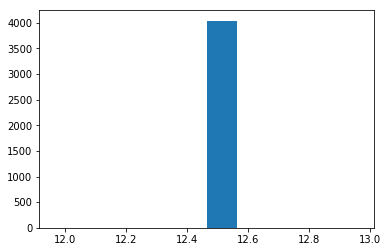

In [41]:
plt.hist(np.log(pred));

**Usuarios que no van a convertir vs usuarios que van a convertir
hay que refinar esto igual, usar un modelo lineal dudo que tenga sentido, hay que probar otros algoritmos, agregar features de los otros datasets y reintentar**

In [42]:
may, men = 0,0
for elem in pred:
    if elem == 60*60*24*3:
        may += 1
    else:
        men += 1
print(may, men)

4037 0


In [43]:
# mean_squared_error(train_vent_2,pred)**0.5